<a href="https://colab.research.google.com/github/jennahgosciak/nyc_fire_risk/blob/main/00_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# setup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import requests
import calendar
import geopandas as gpd
import os.path as os
import scipy.stats
import seaborn.palettes
import seaborn.utils
import sys
from census import Census
from us import states
import http.client, urllib.request, urllib.parse, urllib.error, base64
import config

root= r"C:/Users/Jennah/Desktop/Code/machine-learning-final"
inp= os.join(root, "data", "1_raw")
out= os.join(root, "data", "2_intermediate")

In [2]:
import psycopg2 as psy
# load furman db
connection = psy.connect(
    host="fcdata.c7h93yqbqnvu.us-east-1.rds.amazonaws.com",
    port=5432,
    user = "furmandata",
    password = config.furman_pwd,
    database = "fcdata")
cursor = connection.cursor()

# Estimating Fires in NYC

## Load HPD violations

In [ ]:
## load violations data
viol_df= pd.read_sql_query("""SELECT * FROM hpd_violations""", connection)

In [ ]:
viol_df

In [3]:
# load data on all fire dispate events for structural fires
url_fire_ev = 'https://data.cityofnewyork.us/resource/8m42-w767.csv?$limit=1000000&$where=INCIDENT_CLASSIFICATION_GROUP="Structural%20Fires"'
fire_ev = pd.read_csv(url_fire_ev)
print(fire_ev.shape)

# if false, then we might not have downloaded all data
print(fire_ev.shape[0])
assert fire_ev.shape[0] < 1000000

KeyboardInterrupt: 

In [4]:
fire_ev["incident_classification"].unique()

array(["Multiple Dwelling 'A' - Other fire",
       "Multiple Dwelling 'A' - Compactor fire",
       'Other Commercial Building Fire',
       "Multiple Dwelling 'A' - Food on the stove fire",
       'Private Dwelling Fire', "Multiple Dwelling 'B' Fire",
       'Store Fire', 'Hospital Fire', 'Transit System - Structural',
       'Church Fire', 'Construction or Demolition Building Fire',
       'Other Public Building Fire', 'Factory Fire', 'School Fire',
       'Untenanted Building Fire', 'Theater or TV Studio Fire'],
      dtype=object)

In [5]:
fire_ev= fire_ev.loc[fire_ev["incident_classification"].isin(["Multiple Dwelling 'A' - Other fire",
                                                  "Multiple Dwelling 'A' - Compactor fire",
                                                  "Multiple Dwelling 'A' - Food on the stove fire",
                                                  "Private Dwelling Fire",
                                                  "Multiple Dwelling 'B' Fire",
                                                  "Untenanted Building Fire"]), :].copy()

In [6]:
# create month, date, and year variables
fire_ev["incident_date"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.date
fire_ev["incident_month"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.month
fire_ev["incident_day"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.day
fire_ev["incident_year"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.year

fire_ev["incident_md"]= fire_ev[["incident_month", "incident_day"]].astype(str).apply('-'.join, 1)
print("\nFire events by year")
fire_ev["incident_year"].value_counts().sort_index()


Fire events by year


2005    26182
2006    26270
2007    26364
2008    25226
2009    24960
2010    25234
2011    24038
2012    24220
2013    21452
2014    21822
2015    22501
2016    22599
2017    23218
2018    21874
2019    21256
2020    21102
2021     7223
Name: incident_year, dtype: int64

In [7]:
fire_ev.head()

,starfire_incident_id,incident_datetime,alarm_box_borough,alarm_box_number,alarm_box_location,incident_borough,zipcode,policeprecinct,citycouncildistrict,communitydistrict,...,incident_response_seconds_qy,incident_travel_tm_seconds_qy,engines_assigned_quantity,ladders_assigned_quantity,other_units_assigned_quantity,incident_date,incident_month,incident_day,incident_year,incident_md
0,5.001924e+14,2005-01-01T00:07:32.000,QUEENS,9237,N/SVC RD H. HARDING EXPY & 99 ST,QUEENS,11368.0,110.0,21.0,404.0,...,338,236,3,2,2,2005-01-01,1,1,2005,1-1
1,5.001149e+14,2005-01-01T00:14:40.000,MANHATTAN,1493,BWAY & W125 ST\M.L.KING JR BLVD,MANHATTAN,10027.0,26.0,7.0,109.0,...,266,217,2,2,1,2005-01-01,1,1,2005,1-1
4,5.001065e+14,2005-01-01T00:24:58.000,BROOKLYN,653,LAFAYETTE & CLASSON AVES,BROOKLYN,11238.0,79.0,35.0,303.0,...,226,189,3,2,1,2005-01-01,1,1,2005,1-1
5,5.001165e+14,2005-01-01T00:27:19.000,MANHATTAN,1649,RIVERSIDE DR & 150 ST,MANHATTAN,10031.0,30.0,7.0,109.0,...,274,200,5,3,5,2005-01-01,1,1,2005,1-1
6,5.001165e+14,2005-01-01T00:27:19.000,MANHATTAN,1649,RIVERSIDE DR & 150 ST,MANHATTAN,10031.0,30.0,7.0,109.0,...,274,200,5,3,5,2005-01-01,1,1,2005,1-1


In [8]:
## save file in output folder
fire_ev.to_csv(os.join(out, "fire_dispatch.csv"))

In [9]:
## load in service alarm boxes
alarm_box= gpd.read_file(os.join(inp, "In-Service Alarm Box Locations.geojson"))

## load census tracts
tracts= gpd.read_file("https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Census_Tracts_for_2010_US_Census/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson")

In [10]:
# spatial join to get info
alarm_box_t= gpd.sjoin(alarm_box, tracts, how = "left", op = "intersects")
alarm_box_t.head()

,location,latitude,zip,borobox,communitydistict,longitude,box_type,citycouncil,borough,geometry,...,BoroCode,BoroName,CT2010,BoroCT2010,CDEligibil,NTACode,NTAName,PUMA,Shape__Area,Shape__Length
0,3 AVE & 65 ST,40.63932033,11220,B2653,BK07,-74.02354939,ERS,38,Brooklyn,POINT (-74.02355 40.63932),...,3,Brooklyn,007000,3007000,E,BK31,Bay Ridge,4013,1.609298e+06,7191.182362
1,WOODSIDE AVE & 69 ST,40.7426855,11377,Q7917,QN02,-73.89565167,BARS,26,Queens,POINT (-73.89565 40.74269),...,4,Queens,048300,4048300,E,QN50,Elmhurst-Maspeth,4109,2.399981e+06,7509.356297
2,MYRTLE AVE & PALMETTO ST,40.69953211,11237,B0801,QN05,-73.9110349,ERS,34,Brooklyn,POINT (-73.91103 40.69953),...,3,Brooklyn,043900,3043900,E,BK77,Bushwick North,4002,2.152393e+06,8162.503636
3,NEW YORK AVE & LEFFERTS AVE,40.66253364,11225,B1046,BK09,-73.94791393,ERS,40,Brooklyn,POINT (-73.94791 40.66253),...,3,Brooklyn,080600,3080600,E,BK60,Prospect Lefferts Gardens-Wingate,4011,1.790169e+06,6017.644684
4,RIVER & NORTH 3 STS,40.71837562,11211,B0109,BK01,-73.96462115,ERS,33,Brooklyn,POINT (-73.96462 40.71838),...,3,Brooklyn,055500,3055500,I,BK73,North Side-South Side,4001,2.838296e+06,7349.098694


In [32]:
fire_ev["alarm_box_number_char"]= fire_ev["alarm_box_number"].astype(str).str.pad(width = 4, fillchar = "0")
print(fire_ev[["alarm_box_number_char", "alarm_box_number"]].value_counts().head(10))

alarm_box_number_char  alarm_box_number
1670                   1670                738
0742                   742                 623
4723                   4723                585
2185                   2185                555
2748                   2748                524
0646                   646                 507
3386                   3386                506
1349                   1349                504
1473                   1473                472
1085                   1085                464
dtype: int64


In [47]:
fire_ev["borobox"]= np.select( [fire_ev["alarm_box_borough"] == "QUEENS",\
                               fire_ev["alarm_box_borough"] == "MANHATTAN",\
                               fire_ev["alarm_box_borough"] == "BRONX",\
                               fire_ev["alarm_box_borough"] == "BROOKLYN",\
                               (fire_ev["alarm_box_borough"] == "STATEN ISLAND" )| \
                               (fire_ev['alarm_box_borough'] == "RICHMOND / STATEN ISLAND")], \
                                                                        ["Q" + fire_ev["alarm_box_number_char"],\
                                                                         "M" + fire_ev["alarm_box_number_char"],\
                                                                         "X" + fire_ev["alarm_box_number_char"],\
                                                                         "B" + fire_ev["alarm_box_number_char"],\
                                                                         "R" + fire_ev["alarm_box_number_char"]])
fire_ev

,starfire_incident_id,incident_datetime,alarm_box_borough,alarm_box_number,alarm_box_location,incident_borough,zipcode,policeprecinct,citycouncildistrict,communitydistrict,...,engines_assigned_quantity,ladders_assigned_quantity,other_units_assigned_quantity,incident_date,incident_month,incident_day,incident_year,incident_md,alarm_box_number_char,borobox
0,5.001924e+14,2005-01-01T00:07:32.000,QUEENS,9237,N/SVC RD H. HARDING EXPY & 99 ST,QUEENS,11368.0,110.0,21.0,404.0,...,3,2,2,2005-01-01,1,1,2005,1-1,9237,Q9237
1,5.001149e+14,2005-01-01T00:14:40.000,MANHATTAN,1493,BWAY & W125 ST\M.L.KING JR BLVD,MANHATTAN,10027.0,26.0,7.0,109.0,...,2,2,1,2005-01-01,1,1,2005,1-1,1493,M1493
4,5.001065e+14,2005-01-01T00:24:58.000,BROOKLYN,653,LAFAYETTE & CLASSON AVES,BROOKLYN,11238.0,79.0,35.0,303.0,...,3,2,1,2005-01-01,1,1,2005,1-1,0653,B0653
5,5.001165e+14,2005-01-01T00:27:19.000,MANHATTAN,1649,RIVERSIDE DR & 150 ST,MANHATTAN,10031.0,30.0,7.0,109.0,...,5,3,5,2005-01-01,1,1,2005,1-1,1649,M1649
6,5.001165e+14,2005-01-01T00:27:19.000,MANHATTAN,1649,RIVERSIDE DR & 150 ST,MANHATTAN,10031.0,30.0,7.0,109.0,...,5,3,5,2005-01-01,1,1,2005,1-1,1649,M1649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456371,2.112560e+15,2021-05-05T21:28:00.000,QUEENS,6117,CORBETT RD & 221 ST,QUEENS,11361.0,111.0,19.0,411.0,...,1,1,0,2021-05-05,5,5,2021,5-5,6117,Q6117
456372,2.112510e+15,2021-05-05T21:31:00.000,MANHATTAN,1442,LEXINGTON AVE & 121 ST,MANHATTAN,10035.0,25.0,9.0,111.0,...,4,2,1,2021-05-05,5,5,2021,5-5,1442,M1442
456373,2.112510e+15,2021-05-05T22:23:00.000,MANHATTAN,1325,AMSTERDAM AVE & 109 ST,MANHATTAN,10025.0,24.0,7.0,107.0,...,3,2,1,2021-05-05,5,5,2021,5-5,1325,M1325
456374,2.112530e+15,2021-05-05T23:16:00.000,BRONX,3170,BRYANT AVE & BRONX PARK SO.,BRONX,10460.0,48.0,15.0,206.0,...,3,2,1,2021-05-05,5,5,2021,5-5,3170,X3170


In [52]:
# no 0s!! make sure
assert fire_ev.loc[fire_ev["borobox"] == 0, :].shape[0]==0

### Firebox level data

In [53]:
fire_ev_box= fire_ev.merge(alarm_box_t, on = "borobox", how = "left")
fire_ev_box.head()

,starfire_incident_id,incident_datetime,alarm_box_borough,alarm_box_number,alarm_box_location,incident_borough,zipcode,policeprecinct,citycouncildistrict,communitydistrict,...,BoroCode,BoroName,CT2010,BoroCT2010,CDEligibil,NTACode,NTAName,PUMA,Shape__Area,Shape__Length
0,5.001924e+14,2005-01-01T00:07:32.000,QUEENS,9237,N/SVC RD H. HARDING EXPY & 99 ST,QUEENS,11368.0,110.0,21.0,404.0,...,4,Queens,043702,4043702,E,QN25,Corona,4107,1.951899e+06,5926.803242
1,5.001149e+14,2005-01-01T00:14:40.000,MANHATTAN,1493,BWAY & W125 ST\M.L.KING JR BLVD,MANHATTAN,10027.0,26.0,7.0,109.0,...,1,Manhattan,021100,1021100,E,MN09,Morningside Heights,3802,3.738243e+06,7629.112359
2,5.001065e+14,2005-01-01T00:24:58.000,BROOKLYN,653,LAFAYETTE & CLASSON AVES,BROOKLYN,11238.0,79.0,35.0,303.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.001165e+14,2005-01-01T00:27:19.000,MANHATTAN,1649,RIVERSIDE DR & 150 ST,MANHATTAN,10031.0,30.0,7.0,109.0,...,1,Manhattan,023300,1023300,E,MN04,Hamilton Heights,3802,2.503123e+06,7004.868194
4,5.001165e+14,2005-01-01T00:27:19.000,MANHATTAN,1649,RIVERSIDE DR & 150 ST,MANHATTAN,10031.0,30.0,7.0,109.0,...,1,Manhattan,023300,1023300,E,MN04,Hamilton Heights,3802,2.503123e+06,7004.868194


In [54]:
fire_box_avgs= fire_ev_box.groupby("borobox")[["engines_assigned_quantity", "ladders_assigned_quantity", "highest_alarm_level",\
                                 "dispatch_response_seconds_qy"]].mean().reset_index()
fire_box_counts= fire_ev_box["borobox"].value_counts().reset_index().rename({"index":"borobox", "borobox":"num_fire_ev"},\
                                                                                   axis = 1)
print(fire_box_avgs)
print(fire_box_counts)

fire_box_sum= fire_box_avgs.merge(fire_box_counts, on = "borobox", how = "outer")
fire_box_sum.head()

      borobox  engines_assigned_quantity  ladders_assigned_quantity  \
0       B0018                        3.0                   2.000000   
1       B0020                        3.5                   2.333333   
2       B0023                        3.0                   2.000000   
3       B0024                        3.2                   2.040000   
4       B0025                        2.4                   1.600000   
...       ...                        ...                        ...   
15802   X8931                        2.5                   1.500000   
15803   X8963                        0.0                   0.000000   
15804   X8990                        0.0                   0.000000   
15805   X8995                        1.5                   1.000000   
15806   X9995                        0.0                   0.000000   

       dispatch_response_seconds_qy  
0                         16.000000  
1                         32.666667  
2                         42.3333

,borobox,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev
0,B0018,3.0,2.000000,16.000000,1
1,B0020,3.5,2.333333,32.666667,6
2,B0023,3.0,2.000000,42.333333,3
3,B0024,3.2,2.040000,36.880000,25
4,B0025,2.4,1.600000,15.600000,5


In [55]:
fire_box_sum.to_csv(os.join(out, "fire_box_sum.csv"))

### Tract level summary file (dispatch data)

In [56]:
# create tract level file with counts
fire_ev_tracts= fire_ev.merge(alarm_box_t, on = "borobox", how = "outer")
fire_ev_tracts.to_csv(os.join(out, "fire_dispatch_tracts.csv"))

In [57]:
fire_tract_avgs= fire_ev_tracts.groupby("BoroCT2010")[["engines_assigned_quantity", "ladders_assigned_quantity", "highest_alarm_level",\
                                 "dispatch_response_seconds_qy"]].mean().reset_index()
fire_tract_counts= fire_ev_tracts["BoroCT2010"].value_counts().reset_index().rename({"index":"BoroCT2010", "BoroCT2010":"num_fire_ev"},\
                                                                                   axis = 1)
print(fire_tract_avgs)
print(fire_tract_counts)

fire_tract_sum= fire_tract_avgs.merge(fire_tract_counts, on = "BoroCT2010", how = "outer")
fire_tract_sum.head()

     BoroCT2010  engines_assigned_quantity  ladders_assigned_quantity  \
0       1000201                   3.218978                   2.094891   
1       1000202                   3.271817                   2.160229   
2       1000600                   3.083815                   2.089595   
3       1000700                   2.450000                   1.787500   
4       1000800                   3.222222                   2.093567   
...         ...                        ...                        ...   
2039    5030301                   2.518828                   1.757322   
2040    5030302                   2.457983                   1.806723   
2041    5031901                   3.158301                   2.104247   
2042    5031902                   2.887179                   2.000000   
2043    5032300                   1.932584                   1.516854   

      dispatch_response_seconds_qy  
0                        34.591241  
1                        39.273247  
2           

,BoroCT2010,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev
0,1000201,3.218978,2.094891,34.591241,139
1,1000202,3.271817,2.160229,39.273247,699
2,1000600,3.083815,2.089595,38.008671,346
3,1000700,2.450000,1.787500,43.131250,163
4,1000800,3.222222,2.093567,39.330409,344


In [58]:
fire_tract_sum.to_csv(os.join(out, "fire_tract_sum.csv"))

# Load data on vacate orders from HPD, due to fire
## From January 1st, 2017 through the present

* Order to repair/vacate orders: https://data.cityofnewyork.us/resource/tb8q-a3ar
* Fire Department building vacate list: https://data.cityofnewyork.us/resource/n5xc-7jfa
* Future work: combine old and new vacate orders? First dataset only has 93 records

In [17]:
url_vac_old = 'https://data.cityofnewyork.us/resource/n5xc-7jfa.csv?$limit=1000000'
vac_old = pd.read_csv(url_vac_old)
print("Size of data:", vac_old.shape)
# format date variable
vac_old["vac_date_orig"]= vac_old["vac_date"].copy()
vac_old["vac_date"]= pd.to_datetime(vac_old["vac_date"]).dt.date
vac_old["vac_year"]= pd.to_datetime(vac_old["vac_date"]).dt.year
# sort data
vac_old.sort_values("vac_year", ascending = True).head()

Size of data: (93, 19)


,vac_date,num,pf,location_1,typ,sf,bor,date_of_lif,area_vac,div,...,latitude,longitude,community_board,community_council,census_tract,bin,bbl,nta,vac_date_orig,vac_year
0,2008-05-19,1234,NaN,INTERVALE,AVE,NaN,BX,NaN,ENTIRE BLDG,6,...,40.828940,-73.894516,3.0,17.0,125.0,2010459.0,2.029740e+09,Morrisania-Melrose ...,5/19/2008,2008
1,2008-05-31,1556,NaN,PARKER,ST,NaN,BX,NaN,BASEMENT,6,...,40.838231,-73.850162,10.0,18.0,202.0,2041683.0,2.039720e+09,Westchester-Unionport ...,5/31/2008,2008
2,2009-03-17,1420,NaN,CROTONA,AVE,NaN,BX,NaN,ENTIRE BUILDING,6,...,40.834290,-73.898082,3.0,16.0,151.0,2009823.0,2.029370e+09,Morrisania-Melrose ...,3/17/2009,2009
3,2009-07-03,414,E,140,ST,NaN,BX,NaN,3rd floor and one room 2nd floor,6,...,40.810042,-73.921112,1.0,8.0,39.0,2000289.0,2.022840e+09,Mott Haven-Port Morris ...,7/3/2009,2009
13,2010-12-09,1443,NaN,TAYLOR,AVE,NaN,BX,NaN,BASEMENT FRONT,7,...,40.836275,-73.866172,9.0,18.0,218.0,2028224.0,2.038990e+09,West Farms-Bronx River ...,12/9/2010,2010


In [18]:
# load ALL vacate orders
url_vac_all = 'https://data.cityofnewyork.us/resource/tb8q-a3ar.csv?$limit=1000000'
vac_all = pd.read_csv(url_vac_all)
print(vac_all.shape)

# if false, then we might not have downloaded all data
print(vac_all.shape[0])
assert vac_all.shape[0] < 1000000
vac_all.to_csv(os.join(out, "all_vacate.csv"))

(5792, 20)
5792


In [19]:
# load vacate orders
url_vac = 'https://data.cityofnewyork.us/resource/tb8q-a3ar.csv?$limit=1000000&$where=primary_vacate_reason="Fire%20Damage"'
vac = pd.read_csv(url_vac)
print(vac.shape)

# if false, then we might not have downloaded all data
print(vac.shape[0])
assert vac.shape[0] < 1000000

(2911, 20)
2911


In [20]:
# create date, month, and year variables
vac["vacate_effective_date2"]= pd.to_datetime(vac["vacate_effective_date"]).dt.date
vac["vacate_effective_month"]= pd.to_datetime(vac["vacate_effective_date"]).dt.month
vac["vacate_effective_day"]= pd.to_datetime(vac["vacate_effective_date"]).dt.day
vac["vacate_effective_year"]= pd.to_datetime(vac["vacate_effective_date"]).dt.year

vac["vacate_effective_md"]= vac[["vacate_effective_month", "vacate_effective_day"]].astype(str).apply('-'.join, 1)

In [21]:
# number of fires per year
vac["vacate_effective_year"].value_counts().sort_index()

2012    283
2013    299
2014    250
2015    253
2016    241
2017    311
2018    312
2019    296
2020    274
2021    314
2022     78
Name: vacate_effective_year, dtype: int64

In [22]:
vac_sub= vac["bbl"].value_counts().reset_index().rename({"index":"bbl", "bbl":"num_vac_orders"}, axis = 1)
vac_sub

,bbl,num_vac_orders
0,2.028820e+09,15
1,3.013020e+09,7
2,2.026230e+09,4
3,2.036000e+09,4
4,2.045060e+09,4
...,...,...
2641,2.026780e+09,1
2642,3.011180e+09,1
2643,2.026220e+09,1
2644,3.035900e+09,1


In [23]:
## save file in output folder
vac.to_csv(os.join(out, "fire_vacate.csv"))
vac_sub.to_csv(os.join(out, "fire_vacate_bbl.csv"))

## Load PLUTO

In [6]:
## load pluto
pluto= gpd.read_file(os.join(inp, "nyc_mappluto_21v4_shp/MapPLUTO.shp"))
pluto= pluto.loc[pluto["LandUse"].isin(['01','02','03','04']), ["BBL", "geometry"]].rename({"BBL":"bbl"}, axis = 1)

In [7]:
pluto.shape

(764961, 2)

In [22]:
## load pluto data as points
pluto_df= pd.read_sql_query("""SELECT * FROM mappluto_21v3
                                        WHERE landuse IN ('01', '02', '03', '04')""", connection)

In [24]:
usecols = ["borough", "bbl", "cd", "tract2010", "zipcode", "address", "bldgclass", "landuse", "ownertype", "ownername",
           "lotarea", "bldgarea", "numbldgs", "numfloors", "unitsres", "unitstotal", "assessland", "assesstot",\
           "exempttot", "yearbuilt", "yearalter1", "yearalter2", "sanborn"]

#pluto_df= pd.read_csv(os.join(inp, "nyc_pluto_21v4_csv/pluto_21v4.csv"),
#                      usecols = usecols)
#pluto_df= pluto_df.loc[pluto_df["landuse"].isin([1,2,3,4]), :]
print(pluto_df.shape)
pluto_df= pluto_df[usecols]

(764560, 94)


### Spatial join redlining
* Add to Pluto data via spatial join

In [25]:
## red lining maps
mn_rl= gpd.read_file(os.join(inp, "NYManhattan1937.geojson"))
bk_rl= gpd.read_file(os.join(inp, "NYBrooklyn1938.geojson"))
bx_rl= gpd.read_file(os.join(inp, "NYBronx1938.geojson"))
qn_rl= gpd.read_file(os.join(inp, "NYQueens1938.geojson"))
si_rl= gpd.read_file(os.join(inp, "NYStatenIsland1940.geojson"))

all_rl = gpd.GeoDataFrame(pd.concat([mn_rl, bk_rl, bx_rl, qn_rl, si_rl], ignore_index = True)).to_crs(2263)

In [26]:
pluto_cen= pluto.copy()
pluto_cen["geometry"]= pluto_cen["geometry"].centroid

pluto_rl= gpd.sjoin(pluto_cen, all_rl, how = "left", op = "intersects")
pluto_rl.head()

,bbl,geometry,index_right,name,holc_id,holc_grade,area_description_data
8,1.000110e+09,POINT (980816.820 196061.502),NaN,NaN,NaN,NaN,NaN
10,1.000160e+09,POINT (979214.885 196735.293),NaN,NaN,NaN,NaN,NaN
13,1.000168e+09,POINT (979703.768 197392.064),NaN,NaN,NaN,NaN,NaN
14,1.000168e+09,POINT (979469.316 197192.475),NaN,NaN,NaN,NaN,NaN
15,1.000168e+09,POINT (979829.581 197767.345),NaN,NaN,NaN,NaN,NaN


In [27]:
print(pluto_rl["holc_grade"].unique())

pluto_rl["holc_AB"]= np.where((pluto_rl["holc_grade"] == "A") | \
                              (pluto_rl["holc_grade"] == "B"), 1, 0)

pluto_rl["holc_CD"]= np.where((pluto_rl["holc_grade"] == "C") | \
                              (pluto_rl["holc_grade"] == "D"), 1, 0)

pluto_rl["holc_D"]= np.where((pluto_rl["holc_grade"] == "D"), 1, 0)

[nan 'D' 'B' 'C' 'A' 'E']


<AxesSubplot:>

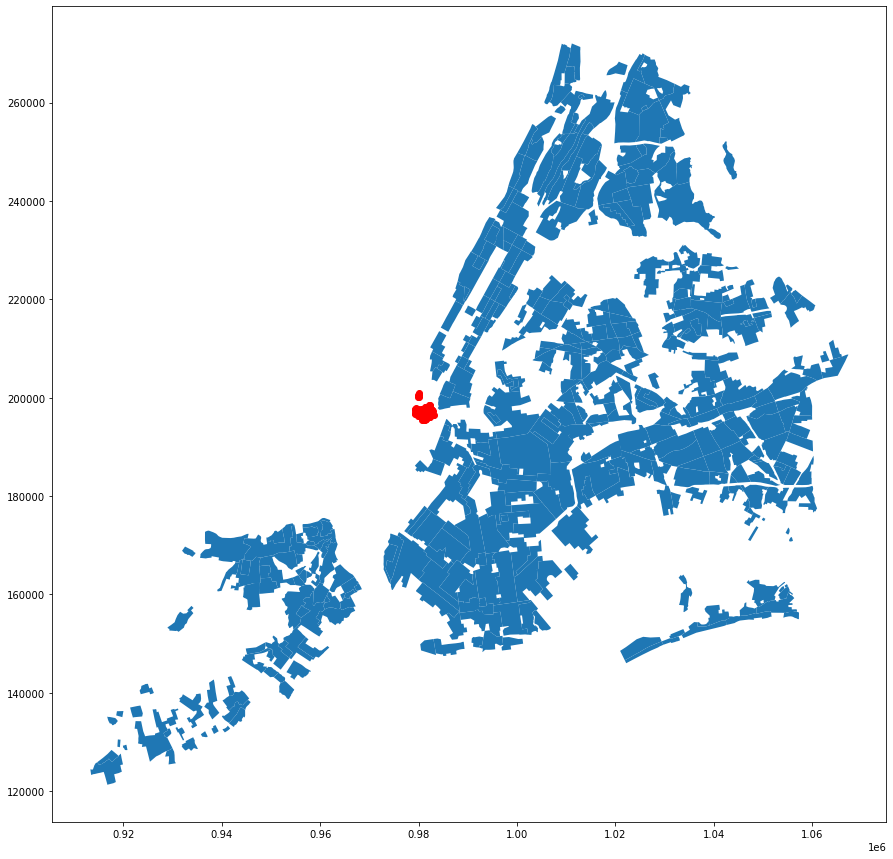

In [28]:
fig, ax = plt.subplots (figsize = (15,15))
all_rl.plot(ax=ax)
pluto_rl.loc[pluto_rl["index_right"].isna()].head(100).plot(ax=ax, color='red')

In [34]:
pluto_rl["bbl"]= pluto_rl["bbl"].astype(str).str.replace(".0", "", regex = False)

In [35]:
## merge to pluto
pluto_df_rl= pluto_df.merge(pluto_rl[["bbl", "holc_AB", "holc_CD", "holc_D"]], on = "bbl", how = "left")

In [43]:
pluto_df_rl["boroct2010"]= pluto_df_rl['bbl'].str[0] + pluto_df_rl['tract2010'].astype(str).str.replace(".", "", regex = False).str.pad(width = 6, side = "right",
                                                                                                                      fillchar = "0")
pluto_df_rl[["boroct2010", "borough", "tract2010"]].head()

assert (pluto_df_rl["boroct2010"].str.len() == 7).all()

In [44]:
landusecols = ["landuse_" + str(x) for x in pluto_df_rl["landuse"].unique()]
bldgclasscols = ["bldgclass_" + str(x) for x in pluto_df_rl["bldgclass"].unique()]
pluto_df_rl= pd.merge(pluto_df_rl, \
                      pd.get_dummies(pluto_df_rl[["bbl", "landuse", "bldgclass"]], columns = ["landuse", "bldgclass"]), on = "bbl")

In [45]:
# save output to intermediate file
# create pluto and vacate orders
pluto_df_rl.to_csv(os.join(out, "pluto_df.csv"))

In [ ]:
## create same file at census tract level level for dispatch data
meancols = ["lotarea", "bldgarea", "numbldgs", "numfloors", "unitsres", "unitstotal", "assessland", "assesstot",\
           "exempttot", "yearbuilt", "holc_AB", "holc_CD", "holc_D"] + landusecols + bldgclasscols
pluto_df_ct= pluto_df_rl.groupby(["borough","ct2010"])[meancols].mean().merge(
                        pluto_df_rl.groupby(["borough","ct2010"])[["bldgclass", "landuse"]].agg(pd.Series.mode), on = "ct2010", how = "outer")
pluto_df_ct

In [ ]:
pluto_df_ct.to_csv(os.join(out, "pluto_ct.csv"))

## Load data on electricity and water usage (Local Law 84)

In [36]:
# store urls
url_2020= "https://data.cityofnewyork.us/resource/usc3-8zwd.csv?$limit=100000"
url_2019= "https://data.cityofnewyork.us/resource/wcm8-aq5w.csv?$limit=100000"
url_2018= "https://data.cityofnewyork.us/resource/4tys-3tzj.csv?$limit=100000"
url_2017= "https://data.cityofnewyork.us/resource/4t62-jm4m.csv?$limit=100000"
url_2016= "https://data.cityofnewyork.us/resource/utpj-74fz.csv?$limit=100000"
url_2015= "https://data.cityofnewyork.us/resource/4t62-jm4m.csv?$limit=100000"
url_2014= "https://data.cityofnewyork.us/resource/nbun-wekj.csv?$limit=100000"
url_2013= "https://data.cityofnewyork.us/resource/yr5p-wjer.csv?$limit=100000"
url_2012= "https://data.cityofnewyork.us/resource/r6ub-zhff.csv?$limit=100000"

# load and append data from each year
urls= [url_2012, url_2013, url_2014, url_2015, url_2016, url_2017, url_2018, url_2019, url_2020]
cols= [["property_id", "year_ending","bbl","weather_normalized_site_eui"],\
      ["property_id", "year_ending", "nyc_borough_block_and_lot", "weather_normalized_site_eui"],\
      ["property_id", "year_ending", "nyc_borough_block_and_lot", "weather_normalized_site_eui"],\
      ["property_id", "year_ending", "nyc_borough_block_and_lot", "weather_normalized_site_eui"],\
      ["property_id", "year_ending", "nyc_borough_block_and_lot", "weather_normalized_site_eui"],\
      ["property_id", "year_ending", "nyc_borough_block_and_lot", "weather_normalized_site_eui"],\
      ["property_id", "year_ending", "nyc_borough_block_and_lot", "weather_normalized_site_eui"],\
      ["property_id", "year_ending", "nyc_borough_block_and_lot", "weather_normalized_site_eui"],\
      ["property_id", "year_ending", "nyc_borough_block_and_lot_bbl", "weather_normalized_site_eui_kbtu_ft"]]
# read in all data files using lc, combine across the rows
dfs= [pd.read_csv(urls[i], usecols = cols[i]) for i in range(5,9)]
dfs

[       property_id              year_ending  nyc_borough_block_and_lot  \
 0          4593574  2017-12-31T00:00:00.000                 1010287502   
 1          6224375  2017-12-31T00:00:00.000  2-00560-0062;2-05560-0062   
 2          2967701  2017-12-31T00:00:00.000               4-01872-0007   
 3          4898531  2017-12-31T00:00:00.000               1-00829-0050   
 4          2917939  2017-12-31T00:00:00.000               1-00828-0053   
 ...            ...                      ...                        ...   
 34681      4047752  2017-12-31T00:00:00.000               3-07018-0018   
 34682      6682473  2017-12-31T00:00:00.000               3-05194-0001   
 34683      6682474  2017-12-31T00:00:00.000               3-01288-0038   
 34684      6682477  2017-12-31T00:00:00.000               3-08716-0085   
 34685      2819133  2017-12-31T00:00:00.000               1-01312-7502   
 
        weather_normalized_site_eui  
 0                             56.2  
 1                    

In [37]:
# make names of columns uniform
for i in range(5,len(dfs)+1):
    dfs[i].columns = cols[0]

In [38]:
# concatenate along rows (i.e. append data from each year)
df_ew= pd.concat(dfs, axis = 0, ignore_index = True)
df_ew

,property_id,year_ending,nyc_borough_block_and_lot,weather_normalized_site_eui,nyc_borough_block_and_lot_bbl,weather_normalized_site_eui_kbtu_ft
0,4593574,2017-12-31T00:00:00.000,1010287502,56.2,NaN,NaN
1,6224375,2017-12-31T00:00:00.000,2-00560-0062;2-05560-0062,NaN,NaN,NaN
2,2967701,2017-12-31T00:00:00.000,4-01872-0007,31.3,NaN,NaN
3,4898531,2017-12-31T00:00:00.000,1-00829-0050,133.7,NaN,NaN
4,2917939,2017-12-31T00:00:00.000,1-00828-0053,80.8,NaN,NaN
...,...,...,...,...,...,...
117077,17286197,2020-12-31T00:00:00.000,NaN,NaN,1-01914-0026,125
117078,17298485,2020-12-31T00:00:00.000,NaN,NaN,4102700059,Not Available
117079,17298486,2020-12-31T00:00:00.000,NaN,NaN,4102700047,Not Available
117080,17321529,2020-12-31T00:00:00.000,NaN,NaN,1014720046,107.1


In [39]:
# text formatting of bbl
df_ew.loc[:, "bbl"]= df_ew.loc[:, "nyc_borough_block_and_lot"].str.replace("[A-z]{1}[0-9]{3}-", "", regex = True)
df_ew.loc[:, "bbl"]= df_ew.loc[:, "bbl"].str.replace("-", "").str.replace(" ", ";")\
                        .str.replace("(?<=[0-9]{10})/", ";", regex = True)\
                        .str.replace("/", "")\
                        .str.replace(",", ";")\
                        .str.replace(":", ";")\
                        .str.replace("and", ";")\
                        .str.replace("&", ";")\
                        .str.replace("NotAvailable", "")\
                        .str.replace("multiple", "")
df_ew.loc[:, ["bbl", "nyc_borough_block_and_lot"]]

,bbl,nyc_borough_block_and_lot
0,1010287502,1010287502
1,2005600062;2055600062,2-00560-0062;2-05560-0062
2,4018720007,4-01872-0007
3,1008290050,1-00829-0050
4,1008280053,1-00828-0053
...,...,...
117077,NaN,NaN
117078,NaN,NaN
117079,NaN,NaN
117080,NaN,NaN


In [40]:
# need to split bbl into several columns
max_num= int(df_ew["bbl"].str.count(";").max())
print(max_num)
df_ew[["bbl" + str(i) for i in range(0, (max_num + 1))]]= df_ew["bbl"].str.split(pat= ";", n=-1, expand = True)
df_ew[["bbl" + str(i) for i in range(0, (max_num + 1))]].head()

41


,bbl0,bbl1,bbl2,bbl3,bbl4,bbl5,bbl6,bbl7,bbl8,bbl9,...,bbl32,bbl33,bbl34,bbl35,bbl36,bbl37,bbl38,bbl39,bbl40,bbl41
0,1010287502,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,2005600062,2055600062,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,4018720007,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,1008290050,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,1008280053,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [41]:
# reshape and reformat bbl column
# pivot data long using melt
cols = [x for x in df_ew.columns if x not in ["bbl" + str(i) for i in range(0, max_num)] + ["bbl"]]
cols

# melt pivots data long
df_ewlong= pd.melt(df_ew.drop("bbl", axis = 1), id_vars=cols,var_name='bbl_num', value_name='bbl')
# recode comparison
print(df_ewlong[["bbl", "nyc_borough_block_and_lot"]].dropna().loc[(df_ewlong["bbl"].dropna()).map(len) > 10, :])

df_ewlong= df_ewlong[(df_ewlong["bbl"].notna()) | (df_ewlong["bbl"].isna() & \
                                                         df_ewlong["bbl_num"] == "bbl0")].drop_duplicates()

                  bbl                          nyc_borough_block_and_lot
61      0004033410037                                    0004-03341-0037
319       1005800065.                                      1-00580-0065.
2061      10193100006                                      1-01931-00006
4018      1005800065.                                      1-00580-0065.
4290      20028110024                                        20028110024
...               ...                                                ...
477831    30605000019  3-06050-0051; 3-06050-0059; 3-06050-00019; 3-0...
482954    05006200200  05-00620-0001; 05-00620-0100; 05-00620-0200; 0...
516925    30605000019  3-06050-0051; 3-06050-0059; 3-06050-00019; 3-0...
541896    30605000019    3060500051; 3060500059; 30605000019; 3060500015
717118    05006200300  05-00620-0001; 05-00620-0100; 05-00620-0200; 0...

[61 rows x 2 columns]


In [42]:
df_ewlong= df_ewlong.rename({"weather_normalized_site_eui":"energy_usage"}, axis = 1)

# drop these values, not useful
df_ewlong= df_ewlong.drop(df_ewlong.loc[(df_ewlong["bbl"].str.len() != 10) | \
                (df_ewlong["bbl"] == "Code9Code9") | \
                (df_ewlong["bbl"] == "Not Available") | \
                (df_ewlong["bbl"] == "XXXXXXXXXX"), :].index, axis = 0)

# drop these values, not useful
df_ewlong= df_ewlong.drop(df_ewlong.loc[(df_ewlong["energy_usage"] == "Code9Code9") | \
                (df_ewlong["energy_usage"] == "Not Available"), :].index, axis = 0)

In [43]:
df_ewlong["year"]= pd.to_datetime(df_ewlong["year_ending"]).dt.year
df_ewlong["energy_usage"]= df_ewlong["energy_usage"].astype(float)

In [44]:
df_ewlong= df_ewlong.loc[~df_ewlong[["bbl", "year", "energy_usage"]].duplicated(), :]
df_ewlong= df_ewlong.groupby(["bbl", "year"])["energy_usage"].mean().reset_index()
df_ewlong

,bbl,year,energy_usage
0,0111690029,2017,547.50
1,0554600053,2019,34.90
2,1000010010,2019,186.80
3,1000020001,2017,120.60
4,1000020001,2018,99.10
...,...,...,...
66331,6000000000,2019,242.20
66332,7000060005,2017,1.90
66333,7000500004,2017,1.90
66334,7019240020,2018,51.70


In [45]:
df_ew_avg= df_ewlong.pivot(index = "bbl", columns = "year", values = "energy_usage").mean(axis = 1).rename("average_energy_usage", axis = 1).reset_index()

In [46]:
# merge to pluto and main df
print(df_ew_avg[["bbl","average_energy_usage"]].head())
assert (df_ew_avg["bbl"].str.len() == 10).all()

df_ew_avg.to_csv(os.join(out, "ll84_avgenergy.csv"))

          bbl  average_energy_usage
0  0111690029            547.500000
1  0554600053             34.900000
2  1000010010            186.800000
3  1000020001            102.800000
4  1000020002              0.966667


## Development Patterns

In [47]:
url= "https://data.cityofnewyork.us/resource/ipu4-2q9a.csv?$LIMIT=1000000&$WHERE=(starts_with(job_type,'A')%20OR%20starts_with(job_type,'N'))%20AND%20residential='YES'%20AND%20permit_status='ISSUED'%20AND%20filing_date>='2012-01-01'%20AND%20filing_status='INITIAL'%20AND%20permit_type%20IN%20('AL','NB')"
dev_perm= pd.read_csv(url, usecols = ["borough", "block", "lot", "job__", "permit_type", "filing_date"])
dev_perm

,borough,job__,block,lot,permit_type,filing_date
0,STATEN ISLAND,520101265,1116,68,NB,2017-02-08
1,QUEENS,420596732,5121,56,AL,2012-08-06
2,BRONX,210177949,4683,72,NB,2019-03-27
3,QUEENS,421261128,2988,46,AL,2016-09-30
4,QUEENS,421325177,9803,37,AL,2016-07-28
...,...,...,...,...,...,...
43988,STATEN ISLAND,520355570,7774,30,NB,2020-06-03
43989,STATEN ISLAND,520355561,7774,28,NB,2020-06-03
43990,STATEN ISLAND,520355552,7774,26,NB,2020-06-03
43991,STATEN ISLAND,520355543,7774,24,NB,2020-06-03


In [48]:
dev_perm.columns
dev_perm["year"]= pd.to_datetime(dev_perm["filing_date"]).dt.year

In [49]:
dev_perm["borough_code"]= np.select( [dev_perm["borough"] == "QUEENS",\
                               dev_perm["borough"] == "MANHATTAN",\
                               dev_perm["borough"] == "BRONX",\
                               dev_perm["borough"] == "BROOKLYN",\
                               dev_perm["borough"] == "STATEN ISLAND"], ["4", "1", "2", "3", "5"])

In [50]:
dev_perm["bbl"]= dev_perm["borough_code"] + dev_perm["block"].astype(str).str.replace(".0", "").str.pad(width = 5, side = "left", fillchar = "0") + \
        dev_perm["lot"].astype(str).str.replace(".0", "").str.pad(width = 4, side = "left", fillchar = "0")
dev_perm["bbl"]

C:\Users\Jennah\AppData\Local\Temp/ipykernel_24128/4145107279.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  dev_perm["bbl"]= dev_perm["borough_code"] + dev_perm["block"].astype(str).str.replace(".0", "").str.pad(width = 5, side = "left", fillchar = "0") + \
C:\Users\Jennah\AppData\Local\Temp/ipykernel_24128/4145107279.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  dev_perm["lot"].astype(str).str.replace(".0", "").str.pad(width = 4, side = "left", fillchar = "0")


0        5011160068
1        4051210056
2        2046830072
3        4029880046
4        4000930037
            ...    
43988    5077740000
43989    5077740028
43990    5077740026
43991    5077740024
43992    5077740033
Name: bbl, Length: 43993, dtype: object

In [51]:
dev_perm_wide= dev_perm[["bbl", "year", "permit_type"]].value_counts().rename("count").reset_index()
dev_perm_wide= dev_perm_wide.pivot(index = ["bbl", "permit_type"], columns = "year", values = "count").fillna(0)

dev_perm_wide["avg_permits"]=dev_perm_wide.mean(axis = 1)
dev_perm_wide= dev_perm_wide.reset_index().pivot(index = "bbl", columns = "permit_type", values = ["avg_permits"] + list(range(2012, 2021))).fillna(0)
dev_perm_wide

avg_permits           2012      2013      2014      2015       \
permit_type          AL        NB   AL   NB   AL   NB   AL   NB   AL   NB   
bbl                                                                         
1000000000     0.444444  0.000000  2.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
1000000001     1.000000  0.000000  1.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0   
1000000002     0.111111  0.000000  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
1000000003     0.222222  0.000000  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
1000000004     0.333333  0.000000  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                 ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
5079410043     0.000000  0.111111  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
5079410045     0.111111  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
5079420032     0.111111  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5079640014     0.000000  0.111111  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
5079960003     0.000000  0.111111  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

            2016      2017      2018      2019      2020       
permit_type   AL   NB   AL   NB   AL   NB   AL   NB   AL   NB  
bbl                                                            
1000000000   0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
1000000001   4.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
1000000002   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1000000003   0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
1000000004   0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
5079410043   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5079410045   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5079420032   0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
5079640014   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5079960003   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  

[35047 rows x 20 columns]

In [52]:
dev_perm_wide.to_csv(os.join(out, "dev_permits.csv"))

## Speculation Watchlist
* List of sales of select rent-regulated multiple dwellings where there may be potential for speculation. This list is promulgated pursuant to Local Law 7 of 2018 and 28 RCNY Chapter 52. This list is a subset of data provided in the LL7-2018 Qualified Transactions file.

In [55]:
url= "https://data.cityofnewyork.us/resource/adax-9mit.csv?$limit=100000"
spec = pd.read_csv(url, usecols = ["bbl"])
spec["speculation"]= 1
spec.to_csv(os.join(out, "speculation_hpd.csv"))

## Load ACRIS Sale Data
* Number of times sold in last 10 years
* Time from most recent sale

In [33]:
acris_sales = pd.read_sql("""with temp as 
                              (select distinct bbl_unit,
                                      bbl_condo,
                                      year from rpad_condo_xwalk_with_pts
                                      where year = 2020)
                            SELECT DISTINCT am.document_id, am.doc_type, am.doc_date,
                                    EXTRACT(YEAR FROM am.doc_date) AS year,
                                    CONCAT(CAST(al.boro as varchar), 
                                            LPAD(CAST(al.block as varchar), 5, '0'),
                                            LPAD(CAST(al.lot as varchar), 4, '0')) as bbl_orig,
                                    COALESCE(temp.bbl_condo, 
                                    CONCAT(CAST(al.boro as varchar), 
                                            LPAD(CAST(al.block as varchar), 5, '0'),
                                            LPAD(CAST(al.lot as varchar), 4, '0'))) as bbl,
                                    am.doc_amount,
                                    al.block,
                                    al.lot,
                                    al.boro
                                    FROM acris_master as am
                                    LEFT JOIN acris_legals as al using(document_id)
                                    LEFT JOIN temp on CONCAT(CAST(al.boro as varchar), 
                                            LPAD(CAST(al.block as varchar), 5, '0'),
                                            LPAD(CAST(al.lot as varchar), 4, '0')) = temp.bbl_unit
                                    WHERE EXTRACT(YEAR FROM doc_date) >= 2012 AND
                                    am.doc_amount > 1 AND am.pct_transferred = 100""", con=connection)

In [34]:
acris_sales.shape

(286899, 10)

In [1]:
acris_sales

NameError: name 'acris_sales' is not defined

In [39]:
acris_sales.to_csv(os.join(inp, "acris_transfers.csv"))